# Семинар 7 - Линейная и гауссовы регрессии

##### Краткий синопсис:
1. Линейная регрессия;
2. AIC, BIC и Bias-Variance decomposition вместе с...
3. ...RVM(Relevant Vector Machine);
4. Gaussian Processes in a nutshell;
5. `GPy`;
6. KISS GP with `Deep Kernel Learing`.

http://scikit-learn.org/stable/modules/linear_model.html

## Технический момент

1. https://docs.docker.com/install/linux/docker-ce/
2. `sudo docker pull vbelavin/jupiter`
3. `sudo docker run -v /home/acapello/:/root/workdir -it -p 8888:8888 vbelavin/jupiter`

In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
np.random.seed(42)
warnings.filterwarnings("ignore")

# 1. Линейная регрессия.

## Про сигналы, фильтры и стабильность$^{\mathrm{TM}}$

### Построим сигнал, который представляет собой модулированную синусоиду

In [2]:
a1 = 10.
a2 = 1.
w1 = 1.
w2 = 12.
N = 256

In [3]:
x = np.linspace(-4, 4, N)
f = a1 * np.sin(w1 * x) + a2 * np.sin(w2 * x)

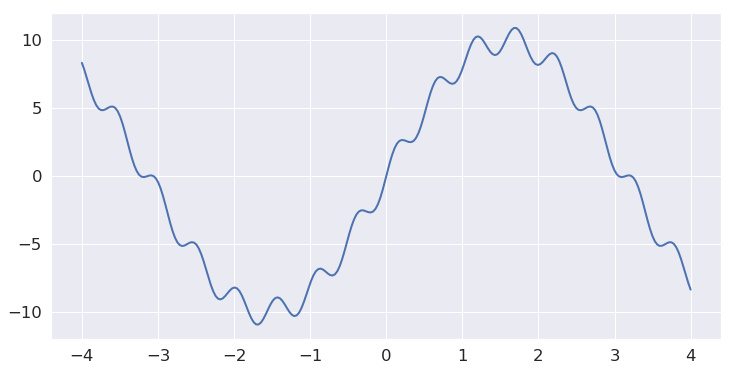

In [4]:
plt.figure(figsize=(12,6))
plt.plot(x, f, linewidth=2)

Сгенерируем оператор, который определяется матрицей $A$ ленточного вида.

Такой оператор соответствует как если бы сигнал обработали moving average, т.е. производит усреднение по некоторому скользящему окну.

In [5]:
A = np.eye(N)
for k in range(1, 15):
    A += np.diag(np.ones(N), k=k)[:N, :N]
    A += np.diag(np.ones(N), k=-k)[:N, :N]

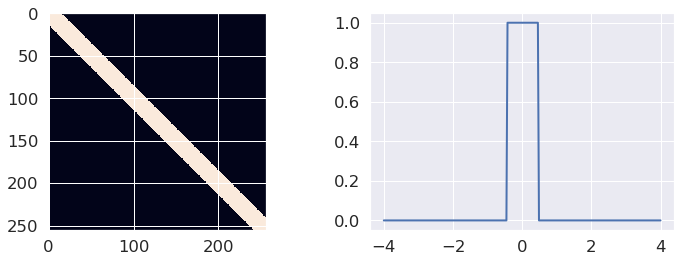

In [6]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].imshow(A)
axs[1].plot(x, A[N // 2,:], linewidth=2)

Сгенерируем выборку $\xi$ умножив нашу диагональную матрицу $A$ на наш сигнал $f$.

Т.е. эффективно сгладив сигнал moving average.

In [7]:
sigma = 2
noise = sigma * np.random.randn(N)
xi = np.dot(A, f) + noise

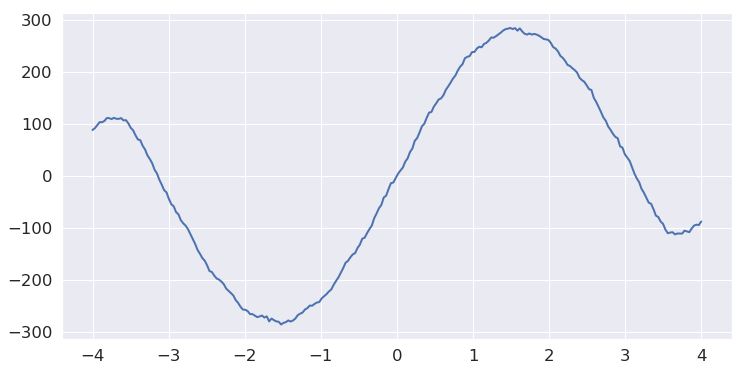

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(x, xi, linewidth=2)

### 1.1 LEAST SQUARES ESTIMATE

Первым делом попробуем восстановить сигнал с помощью LSE, т.е. с помощью метода наименьших квадратов.

$$Af = \xi$$

Матрица псевдорешения(псевдообратная матрица):

$$A^+ = (A^T A)^{-1} A^T$$

Тогда решение можно представить следующим образом:

$$f = A^+ \xi$$

In [9]:
R = np.dot(
        np.linalg.inv(np.dot(A.T, A)),
        A.T
    )
Rxi = np.dot(R, xi)

Text(0.5, 1.0, 'Восстановленный сигнала с помощью LSE')

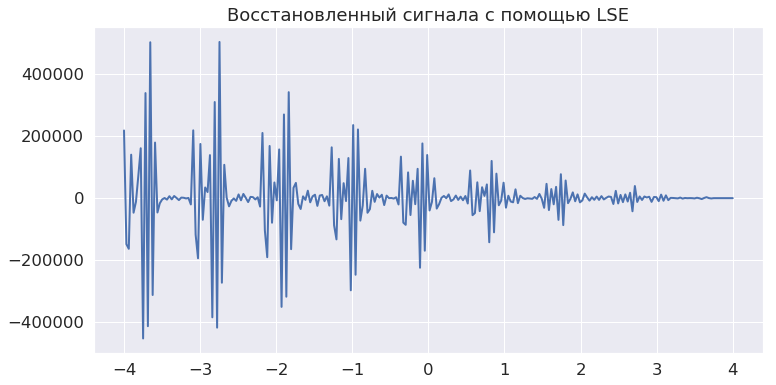

In [10]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi, linewidth=2)
plt.title('Восстановленный сигнала с помощью LSE')

## Что произошло?

Наш вариант реализации псевдообратной является неканоничным и страдает из-за плохих собственных значений.
Поэтому лучше использовать специализированные пакеты, которые более эффективно вычисляют псевдообратные матрицы.

https://en.wikipedia.org/wiki/Generalized_inverse

In [11]:
np.linalg.pinv?

In [12]:
R_pinv = np.linalg.pinv(A)
R_pinv_xi = np.dot(R_pinv, xi)

Text(0.5, 1.0, 'Восстановленный сигнал с помощью np.linalg.pinv')

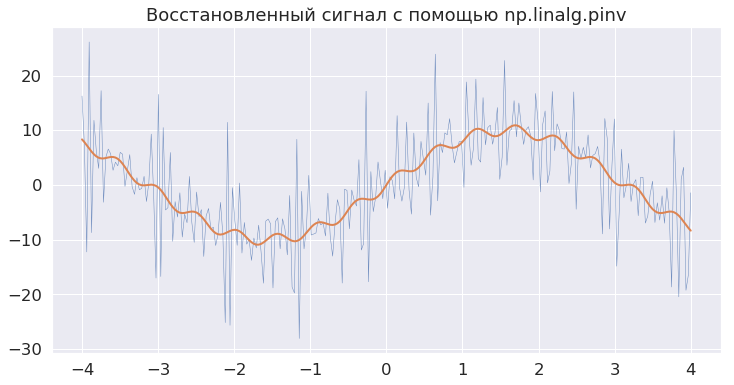

In [13]:
plt.figure(figsize=(12,6))
plt.plot(x, R_pinv_xi, linewidth=0.5, alpha=0.8)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал с помощью np.linalg.pinv')

### NOT QUITE THERE YET. REGULARIZE!

In [14]:
c = 1e-3
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) 
Rxi_reg = np.dot(R_reg, xi)

Text(0.5, 1.0, 'Восстановленный сигнал при включении регуляризации')

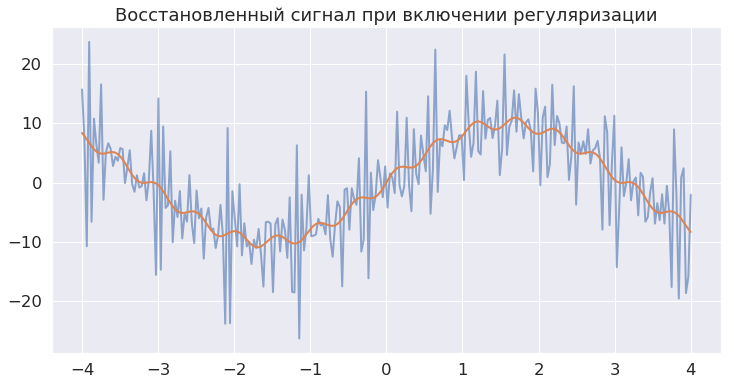

In [15]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

#### Как выбирать коэффициент регуляризации?

In [16]:
reg_coeffs = np.linspace(0.1, 20, 80)
reg_loss = []
for c in reg_coeffs:
    R_reg = np.dot(
            np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
            A.T
        )
    Rxi_reg = np.dot(R_reg, xi)
    loss = np.sum((f - Rxi_reg)**2)
    reg_loss.append(loss)

Text(0.5, 1.0, 'MSE в зависимости от коэффициента регуляризации')

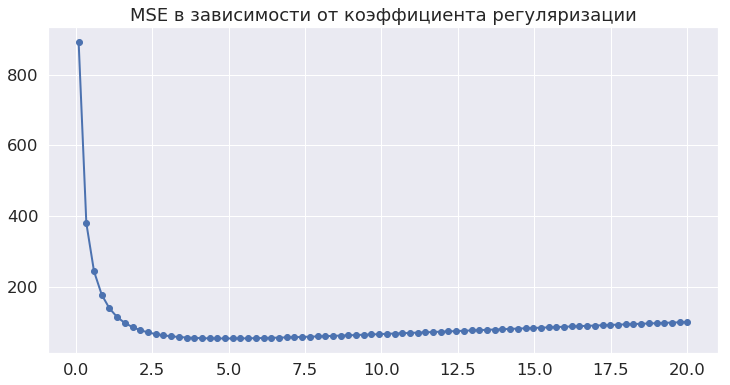

In [17]:
plt.figure(figsize=(12,6))
plt.plot(reg_coeffs, reg_loss, 'o-', linewidth=2)
plt.title('MSE в зависимости от коэффициента регуляризации')

In [18]:
reg_coeffs[np.argmin(reg_loss)]

4.886075949367087

In [19]:
c = 4.886075949367087
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    )
Rxi_reg = np.dot(R_reg, xi)

Text(0.5, 1.0, 'Восстановленный сигнал при включении регуляризации')

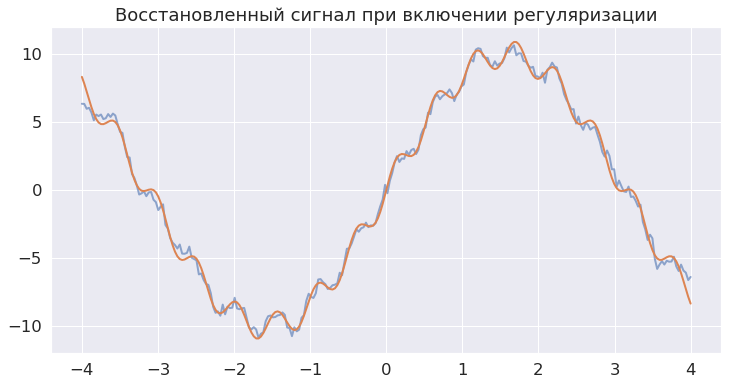

In [20]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

###  SVD

$$A_{n \times m } = U_{m \times m } \Sigma_{m \times n } V_{n \times n }^T$$


![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/1024px-Singular-Value-Decomposition.svg.png)

In [21]:
U, S, V = np.linalg.svd(A)

Text(0.5, 1.0, 'Собственные числа оператора A')

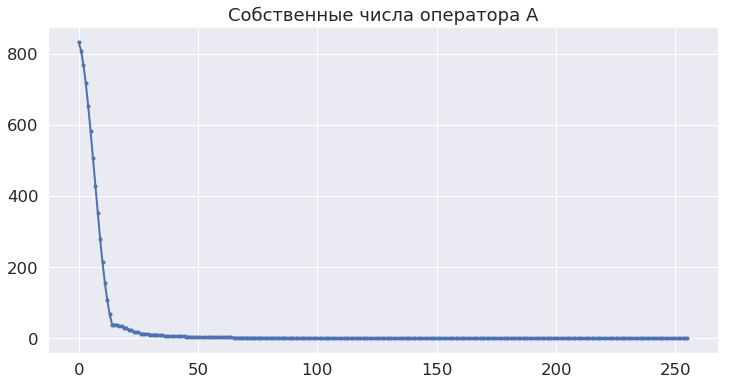

In [22]:
plt.figure(figsize=(12,6))
plt.plot(S**2, '.-', linewidth=2)
plt.title('Собственные числа оператора A')

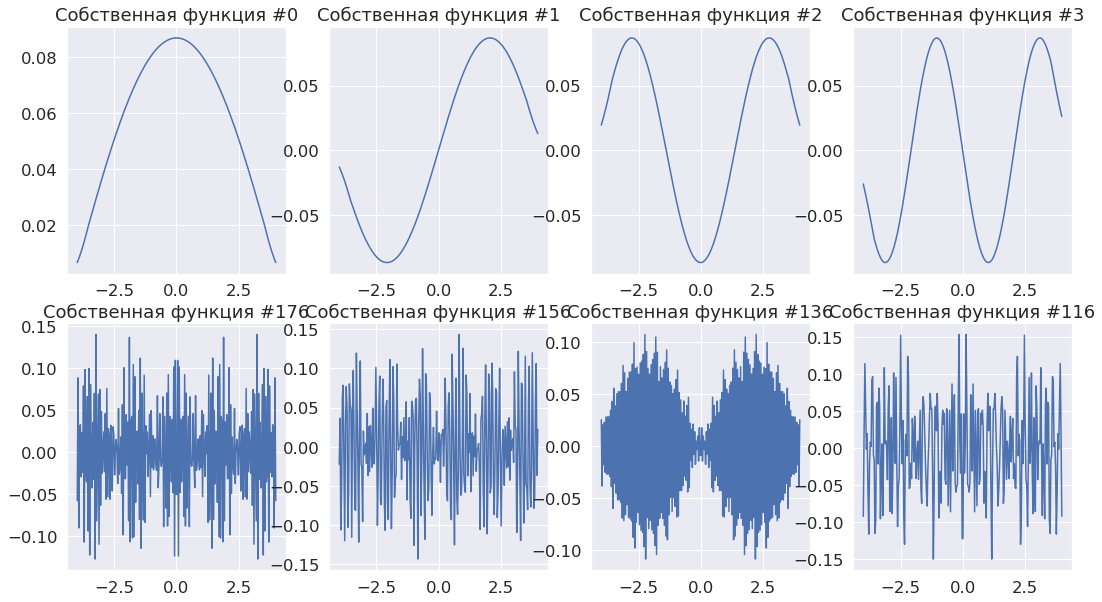

In [23]:
fig, axs = plt.subplots(figsize=(18, 10), ncols=4, nrows=2)
for i in range(4):
    axs[0, i].plot(x, V[i])
    axs[0, i].set_title('Собственная функция #{}'.format(i))
for i in range(4):
    axs[1, i].plot(x, V[N-(4 + i) * 20])
    axs[1, i].set_title('Собственная функция #{}'.format(N-(4 + i) * 20))

###### Какая красота :)

Собственные функции очень похожи на функции Фурье. На самом деле за этими функциями лежит серьёзная математика, которая обобщается парой терминов: матрицы Тёплица.

https://ee.stanford.edu/~gray/toeplitz.pdf

Цитата из Вики:

```
Матрицы Тёплица также связаны с рядами Фурье, потому что оператор умножения на многочлен из синусов или косинусов, спроецированный на конечномерное пространство, можно представить такой матрицей. 
```

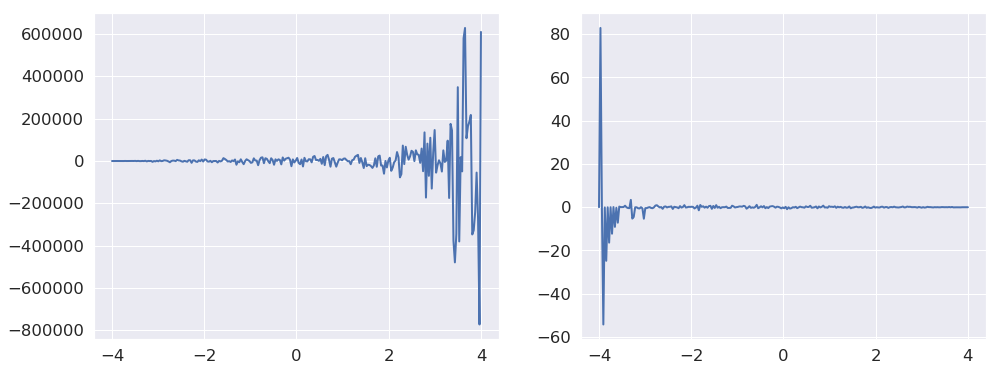

In [24]:
# Отфильтрованный интервал в базисе оператора
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(x, np.dot(V, Rxi), linewidth=2) 
axs[1].plot(x, np.dot(V, Rxi_reg), linewidth=2) 

### Переходим к базису оператора A и сделаем все те же самые трюки что делали раньше

Как перейти к базису оператора A имея матрицы $U$, $V$ и $S$?

$$f_V = V f$$

In [25]:
f_wave = np.dot(V, f) 
noise_wave = np.dot(V, noise) 

In [26]:
A_wave = np.diag(S)

In [27]:
xi_wave = np.dot(A_wave, f_wave) + noise_wave

Text(0.5, 1.0, 'Отфильтрованный сигнал при переходе ')

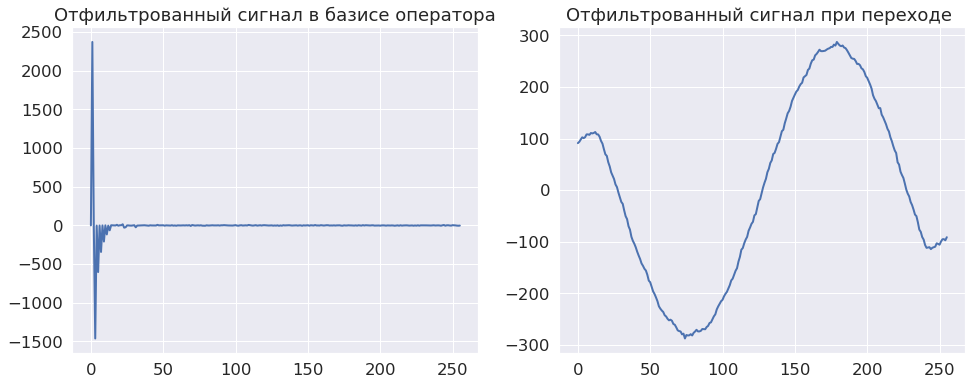

In [28]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)

axs[0].plot(xi_wave, linewidth=2)
axs[0].set_title('Отфильтрованный сигнал в базисе оператора')

# Теперь у нас есть xi_wave -- сигнал в базисе оператора A
# покажем, что это тот самый отфильтрованный сигнал, перейдя обратно в изначальный базис
axs[1].plot(np.dot(V.T, xi_wave), linewidth=2) 
axs[1].set_title('Отфильтрованный сигнал при переходе ')

In [29]:
R_wave = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave)),
        A_wave.T
)
R_wave_xi = np.dot(R_wave, xi_wave)

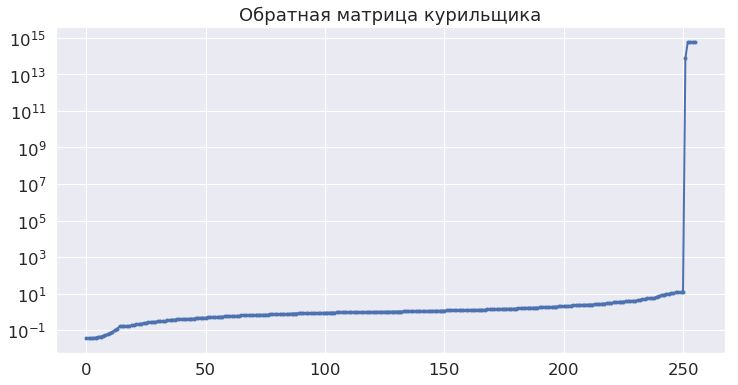

In [30]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_wave), '.-', linewidth=2)
plt.title('Обратная матрица курильщика')
plt.yscale('log')

Text(0.5, 1.0, 'Восстановленный сигнал ')

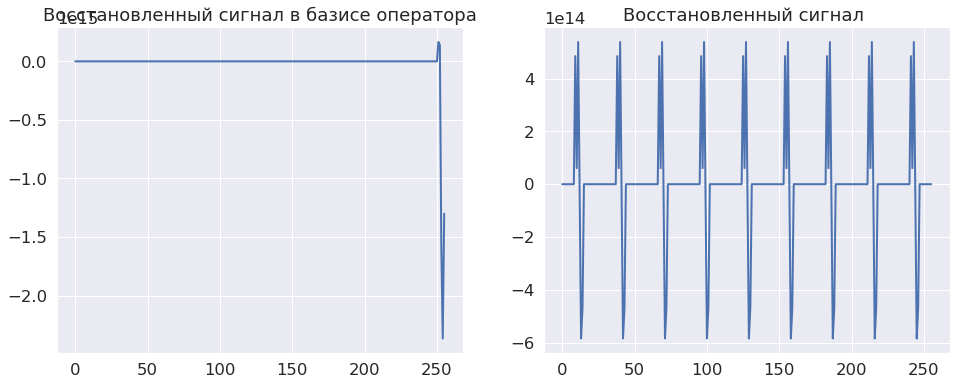

In [31]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(np.dot(V.T, R_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [32]:
R_pinv_wave = np.linalg.pinv(A_wave)
R_pinv_wave_xi = np.dot(R_pinv_wave, xi_wave)

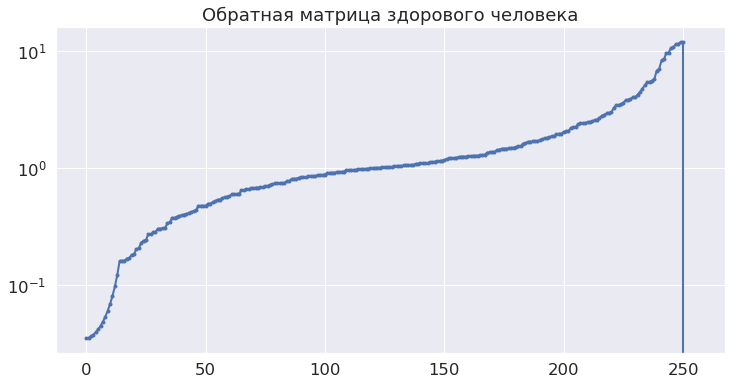

In [33]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_pinv_wave), '.-', linewidth=2)
plt.title('Обратная матрица здорового человека')
plt.yscale('log')

Text(0.5, 1.0, 'Восстановленный сигнал ')

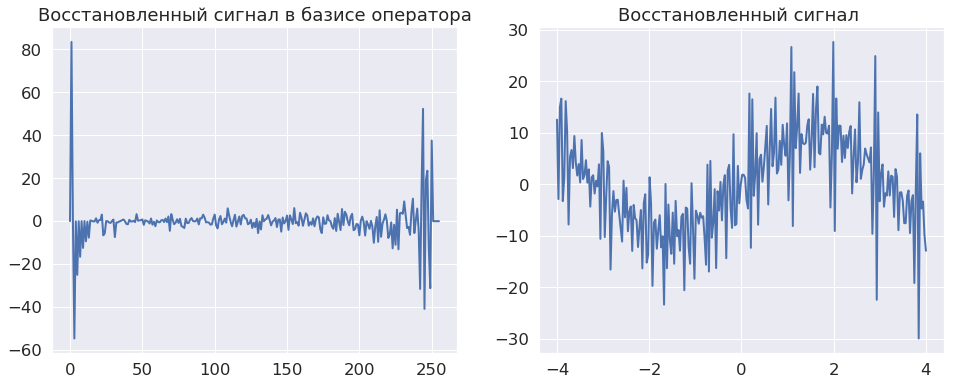

In [34]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_pinv_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(x, np.dot(V.T, R_pinv_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [35]:
c = 5.21
R_wave_reg = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave) + c * np.eye(N)),
        A_wave.T
    )
R_wave_xi_reg = np.dot(R_wave_reg, xi_wave)

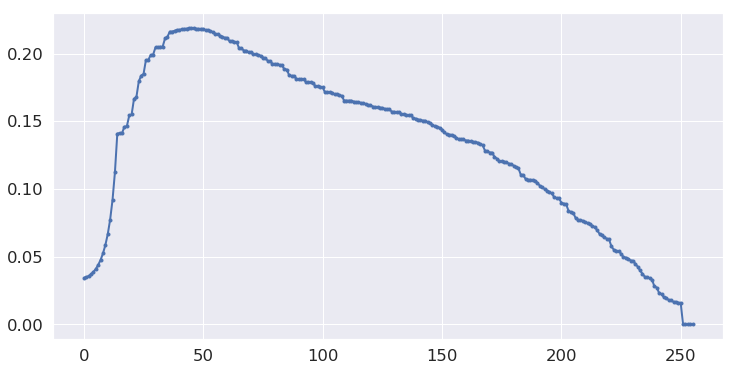

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(np.diag(R_wave_reg), '.-', linewidth=2)

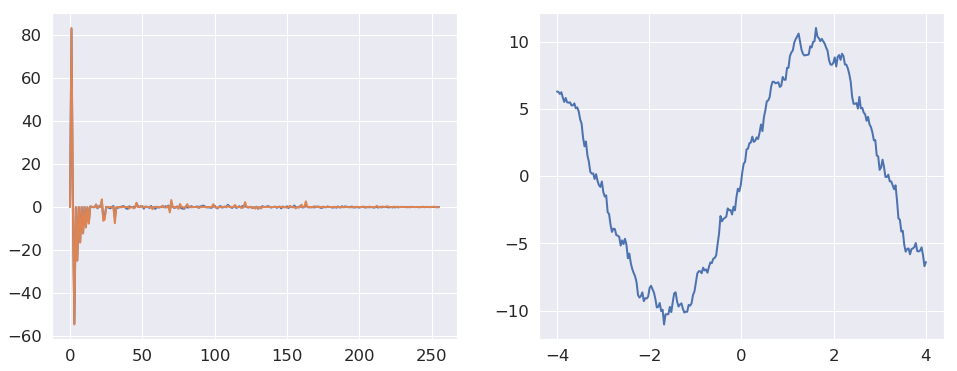

In [37]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi_reg, linewidth=2)
axs[0].plot(f_wave, linewidth=2)
axs[1].plot(x, np.dot(V.T, R_wave_xi_reg), linewidth=2)

# 2. AIC, BIC, CV и bias-variance decomposition


## AIC
 

$$\text{AIC} = −2 \log(L(\theta|\mathrm{data})) + 2K$$

Для LR:

$$\text{AIC} = n \log(\text{RSS}/n) + 2K,$$

где $n$ -- количество объектов в выборке, $K$ -- количество параметров модели.



__Интересный факт:__

AIC асимптотически эквивалентен $Leave-One-Out$ кросс-валидации для любой модели машинного обучения.

[AIC can be shown to be equivalent to leave-one-out cross-validation](http://www.jstor.org/stable/2984877).



## BIC


$$\text{BIC} = −2 \log(L(\theta|\mathrm{data})) + \log(n) K$$

__Интересный факт:__

BIC для линейной модели асимптотически эквивалентен $Leave-v-Out$ кросс-валидации, где $v=n\left[ 1 - \frac{1}{\log{(n)}  - 1} \right]$.


### Как выбирать между AIC и BIC?

Есть ещё один вывод, который можно сделать из работы Shao. BIC выбирает с большей вероятностью верную модель, если такая есть. Но это очень сильное утверждение, что среди набора моделей, которая является верной, т.е. описывает данные. 

С другой стороны, AIC чаще выбирает модель, которая показывает более хороший результат. 

## Mallow's $C_p$ Statistic


$$C_p = MSE + \frac{2}{\hat{\sigma}^2} n K$$

In [38]:
import statsmodels.api as sm

In [39]:
from sklearn.model_selection import train_test_split
N = 250

x = np.linspace(-6, 6, N)
X = np.vstack([
    x, 
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
]).T
Y = 5 + 2 * x + x**2 - 2 * x**3 + np.random.randn(*x.shape)

X_train, X_test, Y_train, Y_test = X[:len(X) // 2], X[len(X) // 2:], Y[:len(X) // 2], Y[len(X) // 2:]

In [40]:
res = sm.OLS(Y_train, X_train).fit()

In [41]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     144.4
Date:                Wed, 16 Jan 2019   Prob (F-statistic):           4.95e-49
Time:                        14:15:00   Log-Likelihood:                -703.52
No. Observations:                 125   AIC:                             1417.
Df Residuals:                     120   BIC:                             1431.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -46.7513      1.837    -25.449      0.000     -50.389     -43.114
x2           -77.7334     72.570     -1.071      0.286    -221.417      65.950
x3           -94.6262     66.682     -1.419      0.158    -226.652      37.399
x4           -14.7852     67.920     -0.218      0.828    -149.263     119.692
x5            61.7563     64.598      0.956      0.341     -66.144     189.656
==============================================================================
Omnibus:                       29.977   Durbin-Watson:                   0.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.878
Skew:                           1.313   Prob(JB):                     8.06e-10
Kurtosis:                       4.072   Cond. No.                         46.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

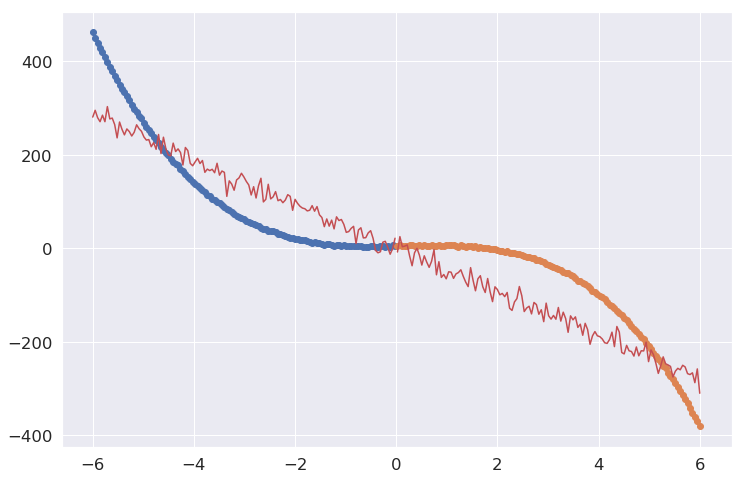

In [42]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], Y_train)
plt.plot(X_train[:, 0], res.predict(X_train), c='r')


plt.scatter(X_test[:, 0], Y_test)
plt.plot(X_test[:, 0], res.predict(X_test), c='r')
plt.show()

In [43]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4).fit(X)
X_train_poly = poly.transform(X_train)

In [44]:
res = sm.OLS(Y_train, X_train_poly).fit()

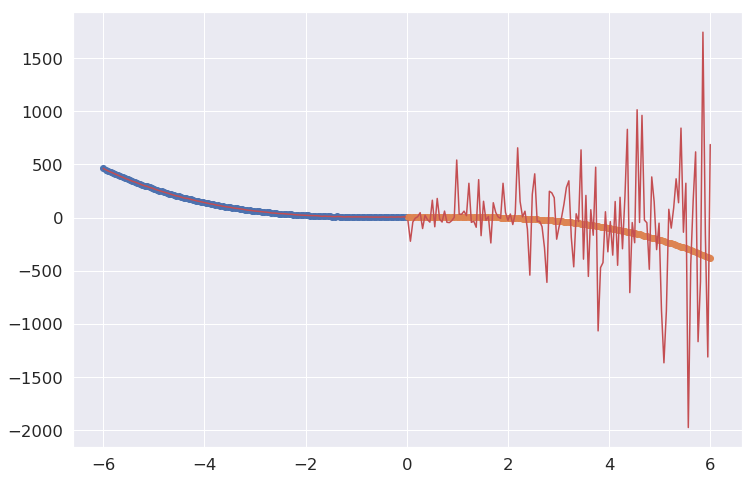

In [45]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], Y_train)
plt.plot(X_train[:, 0], res.predict(X_train_poly), c='r')


plt.scatter(X_test[:, 0], Y_test)
plt.plot(X_test[:, 0], res.predict(poly.transform(X_test)), c='r')
# plt.xlim(-5, 0)
# plt.ylim(0, 20)
plt.show()

# RVM

### Relevance Vector Machine

Метод релевантных векторов -- линейная регрессия под амфетамином с дисперсиями и байесовскими методами.

Задача ставится классическим образом: построить модель зависимости для выборки вида $(X, y) = \{ x_i, y_i \}_{i=1}^N$. Причём мы

$$f(x_i) = w^T x_i$$

#### Вероятностная интерпретация линейной регрессии

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) = \prod\limits_{i=1}^{N} \mathcal{N}(y_i | w^T x_i, \sigma^2) =$$

$$= \frac{1}{\sigma^n (2 \pi)^{n/2}} \exp \left( - \frac{\sum\limits_{i=1}^{N} (y_i - w^T x_i)^2}{2 \sigma^2} \right)$$

Переходим к лагорифму:

$$\log p(y|X, w) = -\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 \rightarrow \max_{w}$$



#### Добавление регуляризации с точки зрения байесовских методов

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) p(w), ~~~ p(w) = \mathcal{N}(w | 0, \alpha^{-1})$$


$$-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 - \frac{\alpha}{2} ||w||_2^2 \rightarrow \max_{w}$$

Другими словами, l2-регуляризация эквивалентна тому что мы вешаем на веса априорную плотность.



Минусы: \sigma^2$ и $\alpha$ одни для всех признаков и фиксированы(нужна кросс-валидация);

### RVR...
...или почему бы нам не добавить распределение на параметры распределения параметров распределения?

$$p(w|\alpha) = \mathcal{N}(0, A^{-1}),~~~A=\mathrm{diag}(\alpha_1, \dots, \alpha_m)$$

Тогда используя сложную математику(см. [1]) можно придумать как обучать такую модель где для каждого признака будет своя собственная дисперсия, которая подбирается автоматически.

[1] http://www.machinelearning.ru/wiki/images/4/43/BayesML-2007-textbook-2.pdf

[2] http://www.machinelearning.ru/wiki/index.php?title=RVM

In [46]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [48]:
from skbayes.rvm_ard_models import RVR
from sklearn.linear_model import LinearRegression

In [49]:
rvm = RVR(kernel='linear')
rvm.fit(X_train, Y_train)

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [50]:
Y_pred_rvm, Y_pred_std = rvm.predict_dist(X_test)
Y_pred_lr = lr.predict(X_test)

mean_squared_error(Y_pred_rvm, Y_test), mean_squared_error(Y_pred_lr, Y_test)

(47507.70463831276, 47444.33822397743)

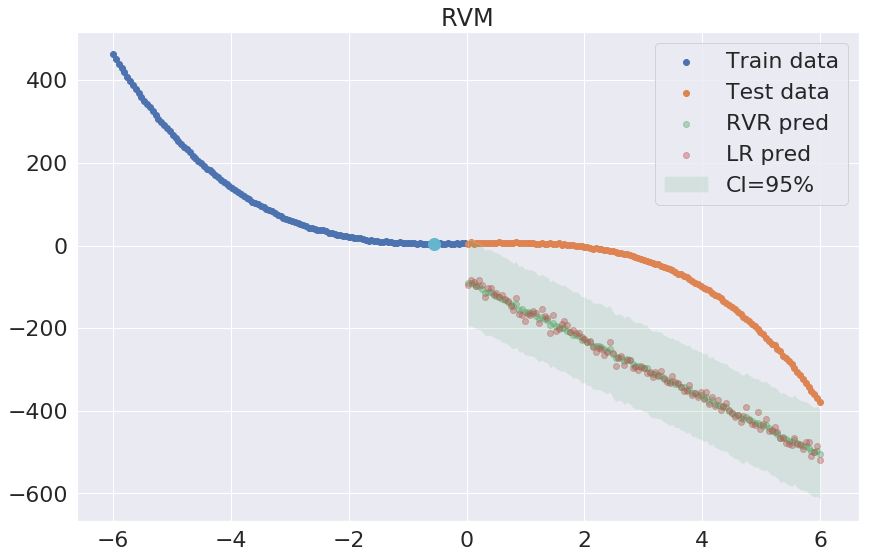

In [51]:
plt.figure(figsize = (14, 9))

plt.scatter(X_train[:, 0], Y_train, label = "Train data")
plt.scatter(X_test[:, 0], Y_test, label = "Test data")
plt.scatter(X_test[:, 0], Y_pred_rvm, label = "RVR pred", alpha=0.4)
plt.scatter(X_test[:, 0], Y_pred_lr, label = "LR pred", alpha=0.4)

plt.fill_between(X_test[:, 0], 
                 Y_pred_rvm - 2 * np.sqrt(Y_pred_std), 
                 Y_pred_rvm + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.plot(rvm.relevant_vectors_[:, 0], Y_train[rvm.active_], "co", markersize = 12)
plt.legend()
plt.title("RVM")
plt.show()

## Bias-Variance


$$\text{Var}(\hat{y}) = E[\hat{y} - y]^2 - (E[\hat{y} - y])^2 $$

$$E[\hat{y} - y]^2 = \text{Var}(\hat{y}) + \text{Bias}(\hat{y})^2$$


Среднее:

$$\bar{y} = \frac{1}{N} \sum \hat{y}_i$$

Тогда смещение определяется так:

$$\text{Bias}(\hat{y})^2=MSE(y, \bar{y})$$

А дисперсия так:

$$\text{Var}(\hat{y})=\frac{1}{N} \sum MSE(\hat{y}_i, \bar{y})$$

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm

In [53]:
def mallow_cp(res, x):
    sigma = 1 / (x.shape[0] - x.shape[1]) * np.dot(res, res)
    risk = np.dot(res, res)
    return risk + 2 * x.shape[1] * sigma

In [54]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [55]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, cross_validate
from sklearn.linear_model import LinearRegression
import math

In [56]:
bias_rvr = []
variance_rvr = []
error_rvr = []

bias_lr = []
variance_lr = []
error_lr = []

aics = []
bics = []
loocvs = []
kfoldcvs = []
mallow_cps = []

degrees = np.arange(1, 7)
resamples = 20

for degree in tqdm(degrees):
    
    Y_preds_rvr = []
    Y_preds_lr = []
    aics_tmp = []
    bics_tmp = []
    loocvs_tmp = []
    kfoldcvs_tmp = []
    mallow_cps_tmp = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        rvm = RVR(kernel='poly', degree=degree).fit(X_train_resample, Y_train_resample)
        Y_pred_rvr = rvm.predict(X_test)
        Y_preds_rvr.append(Y_pred_rvr)
        
        poly = PolynomialFeatures(degree=degree).fit(X)
        X_train_poly_resample = poly.transform(X_train_resample)
        
        lr = sm.OLS(Y_train_resample, X_train_poly_resample).fit()
        aics_tmp.append(lr.aic)
        bics_tmp.append(lr.bic)
        mallow_cps_tmp.append(mallow_cp(res=lr.predict() - Y_train_resample, x=X_train_poly_resample))
        loocvs_tmp.append(np.mean(cross_val_score(SMWrapper(sm.OLS), X_train_poly_resample, Y_train_resample, 
                                                 cv=LeaveOneOut(), scoring='neg_mean_squared_error')))
        n = len(X_train_resample)
        kfoldcvs_tmp.append(np.mean(cross_val_score(SMWrapper(sm.OLS), X_train_poly_resample, Y_train_resample, 
                                                    cv=KFold(int(n * (1 - 1 / (math.log(n) - 1)))), scoring='neg_mean_squared_error')))
        
        Y_pred_lr = lr.predict(poly.transform(X_test))
        Y_preds_lr.append(Y_pred_lr)
    
    aics.append(np.mean(aics_tmp))
    bics.append(np.mean(bics_tmp))
    loocvs.append(-np.mean(loocvs_tmp))
    kfoldcvs.append(-np.mean(kfoldcvs_tmp))
    mallow_cps.append(np.mean(mallow_cps_tmp))
    
    Y_preds_rvr = np.array(Y_preds_rvr)
    bias_rvr.append(
        ((Y_preds_rvr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_rvr.append(
        ((Y_preds_rvr - Y_preds_rvr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_rvr.append(
        ((Y_preds_rvr - Y_test)**2).mean(axis=1).mean()
    )
    
    Y_preds_lr = np.array(Y_preds_lr)
    bias_lr.append(
        ((Y_preds_lr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_lr.append(
        ((Y_preds_lr - Y_preds_lr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_lr.append(
        ((Y_preds_lr - Y_test)**2).mean(axis=1).mean()
    )
    
bias_rvr = np.array(bias_rvr)
variance_rvr = np.array(variance_rvr)
error_rvr = np.array(error_rvr)

bias_lr = np.array(bias_lr)
variance_lr = np.array(variance_lr)
error_lr = np.array(error_lr)

100%|██████████| 6/6 [01:38<00:00, 20.86s/it]


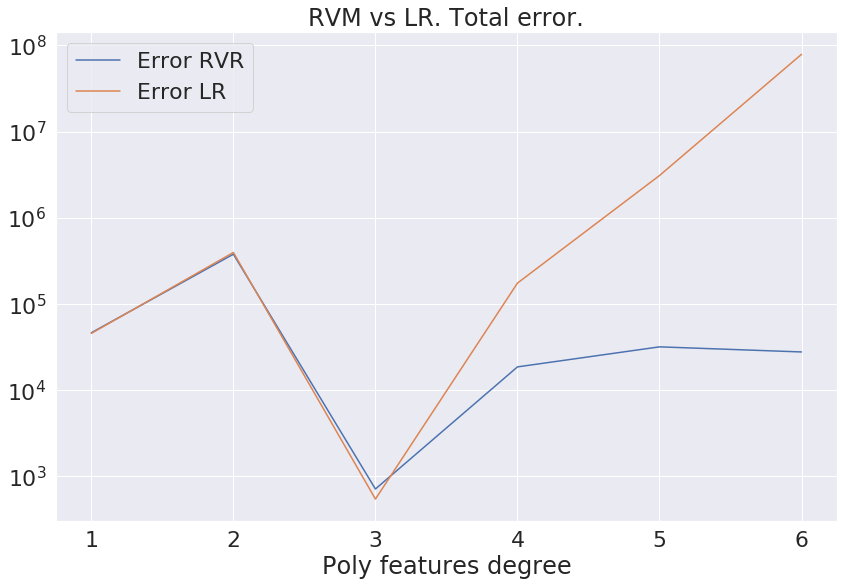

In [57]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, error_rvr, label='Error RVR')
plt.plot(degrees, error_lr, label='Error LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total error.")
plt.xlabel("Poly features degree")
plt.show()

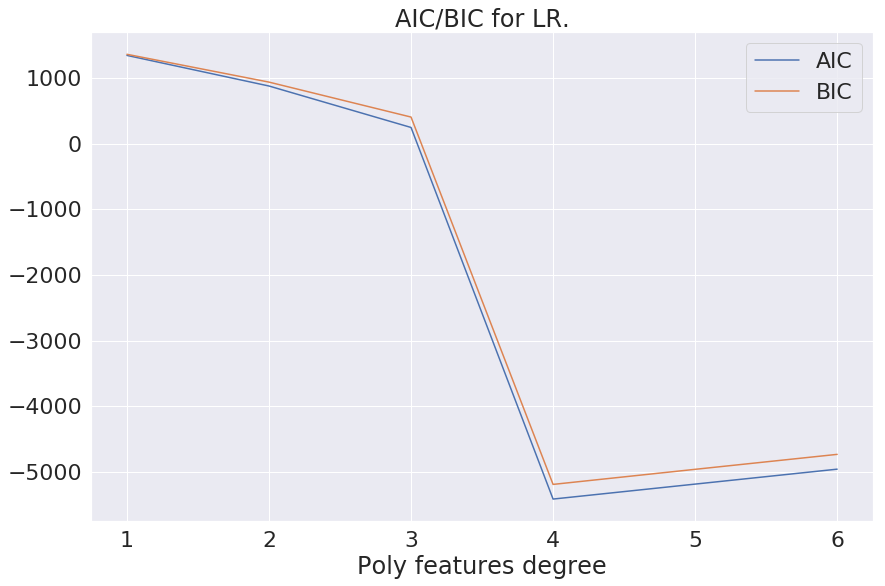

In [58]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, aics, label='AIC')
plt.plot(degrees, bics, label='BIC')
plt.legend()
plt.title("AIC/BIC for LR.")
plt.xlabel("Poly features degree")
plt.show()

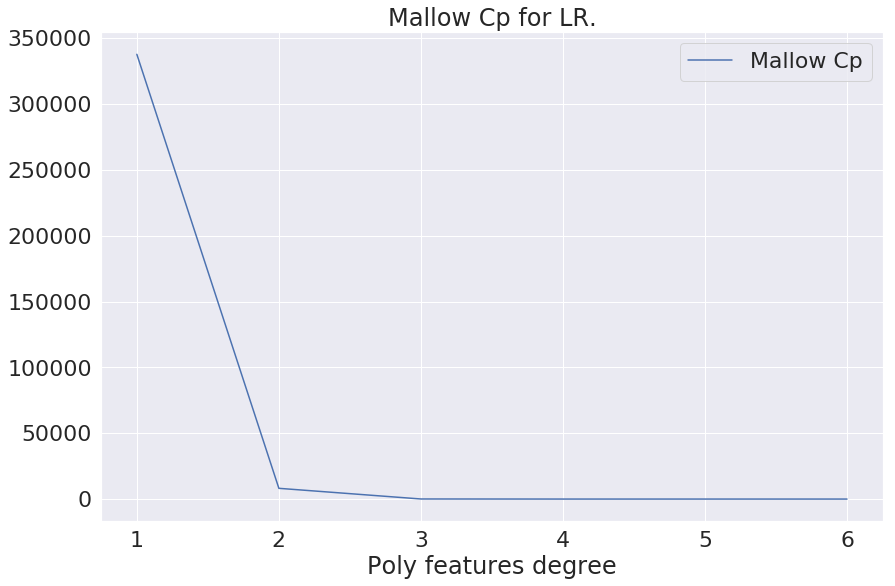

In [59]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, mallow_cps, label='Mallow Cp')
plt.legend()
plt.title("Mallow Cp for LR.")
plt.xlabel("Poly features degree")
#plt.yscale('log')
plt.show()

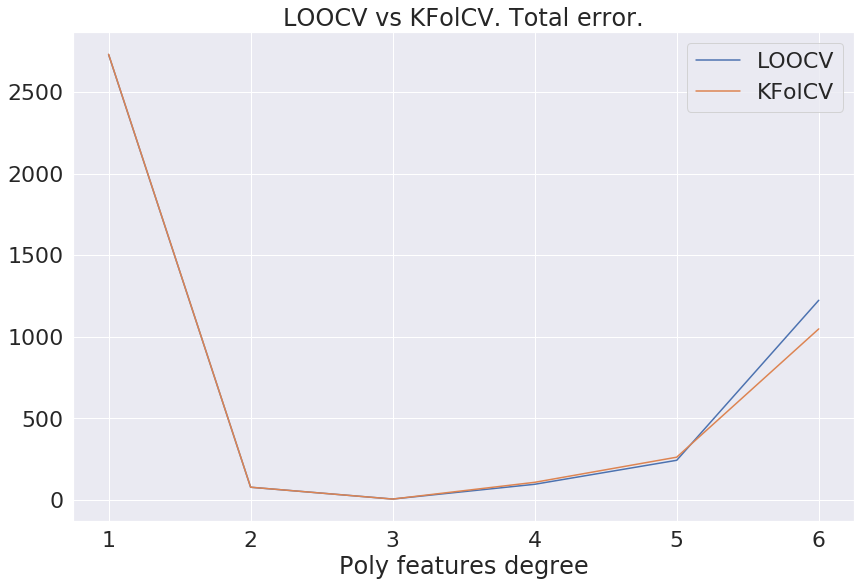

In [60]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, loocvs, label='LOOCV')
plt.plot(degrees, kfoldcvs, label='KFolCV')
plt.legend()
plt.title("LOOCV vs KFolCV. Total error.")
plt.xlabel("Poly features degree")
plt.show()

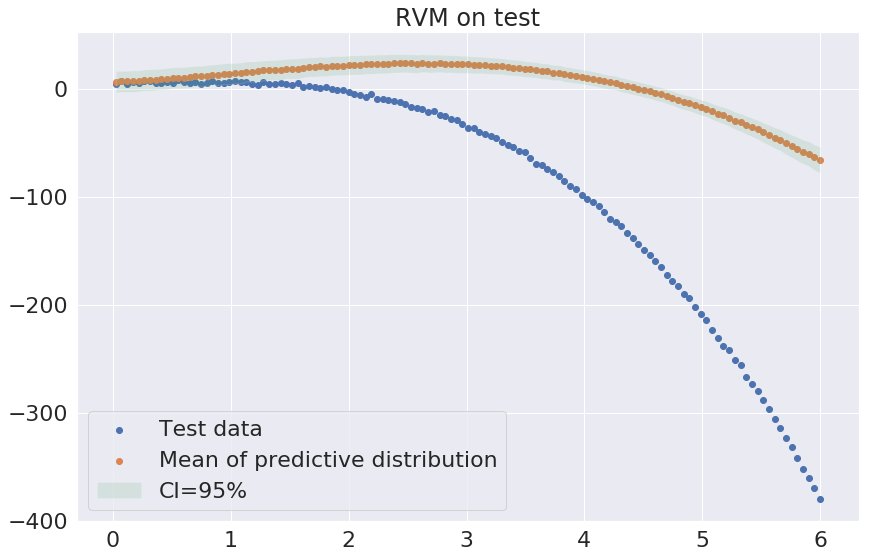

In [61]:
rvm = RVR(kernel='poly', degree=4).fit(X_train, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(X_test)

plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "Test data")
plt.scatter(X_test[:, 0], Y_pred, label = "Mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM on test")
plt.show()

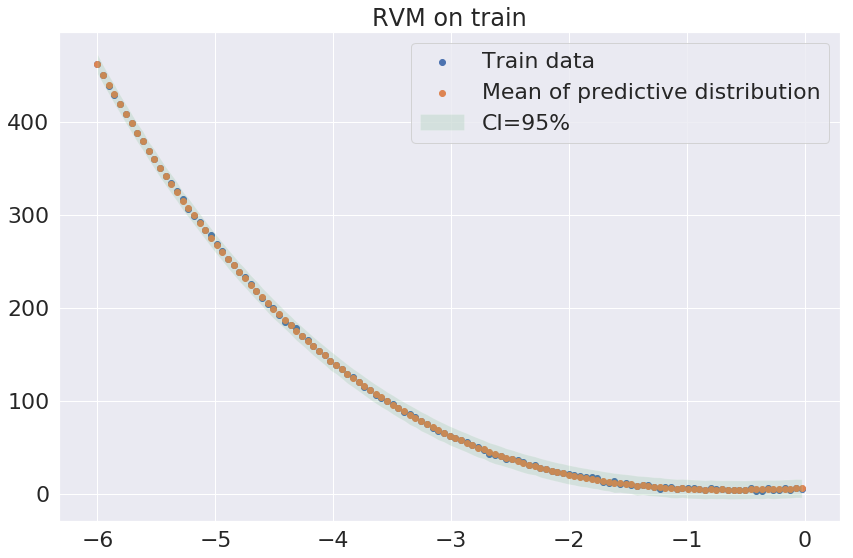

In [62]:
rvm = RVR(kernel='poly', degree=4).fit(X_train, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(X_train)

plt.figure(figsize = (14, 9))
plt.scatter(X_train[:, 0], Y_train, label = "Train data")
plt.scatter(X_train[:, 0], Y_pred, label = "Mean of predictive distribution")
plt.fill_between(X_train[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM on train")
plt.show()

# Gaussian Processes

## План

  * Напишем свой простейший GP;
  * Посмотрим на библиотеку `GPy`;
  * С помощью `GPytorch` научимся использовать Scalable GP;
  * Научимся объединять Deep Learning с GP.
  

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
EPS = 1e-10
sns.set()
warnings.filterwarnings("ignore")

def plot_gp(X_train, y_train, X_test, samples, mu, std):
    plt.figure(figsize=(12, 12))


    plt.plot(X_test, samples.T)

    plt.fill_between(X_test.ravel(), 
                     mu.ravel() - 2 * std.ravel(), 
                     mu.ravel() + 2 * std.ravel(), alpha=0.3)

    plt.plot(X_test, mu, 'r--', lw=2, label='Mean of GP')
    
    plt.scatter(X_train, y_train, s=30, label='Original data')

    plt.title('GP')

    plt.legend()

    plt.show()

## Распределения: совместные, условные, частные

Совместное распределение:

$$(x, y) \sim \mathcal{N}\left(\mu, \Sigma\right), ~\mu = [\mu_1, \mu_2], ~~\Sigma=\begin{bmatrix}\Sigma_{11} & \Sigma_{12} \\ \Sigma_{11}^T & \Sigma_{22} \end{bmatrix}$$

Частное:

$$x \sim  \mathcal{N}(\mu_1, \Sigma_{11})$$


Условное:

$$ (x | y) \sim \mathcal{N}(\mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(y - \mu_2), \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{12}^T)$$

In [64]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[2., 1.5], 
                     [1.5, 2.]])
}

##### Совместное и частные распределения:

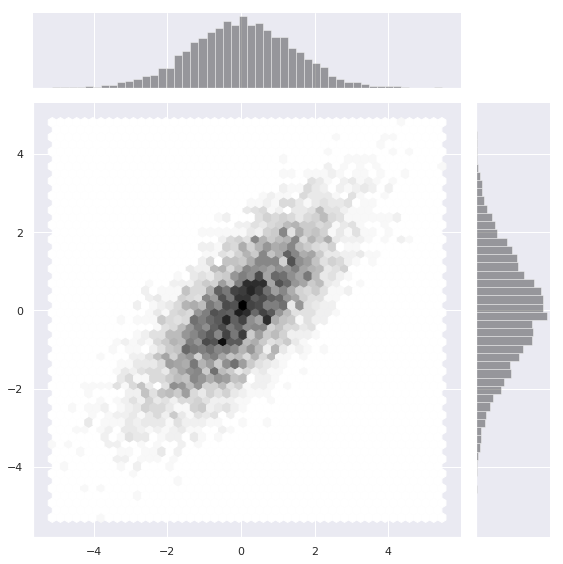

In [65]:
X_sample = np.random.multivariate_normal(size=5000, **parameters)
sns.jointplot(x=X_sample[:, 0], y=X_sample[:, 1], kind="hex", color="k", size=8);

##### Условные распределения:

In [66]:
y = np.linspace(-5, 5, 1000)

In [67]:
mu = parameters['mean'][0] + parameters['cov'][0, 1] * (y - parameters['mean'][1]) / parameters['cov'][1, 1]

var = parameters['cov'][0, 0] - parameters['cov'][0, 1]**2 / parameters['cov'][1, 1]

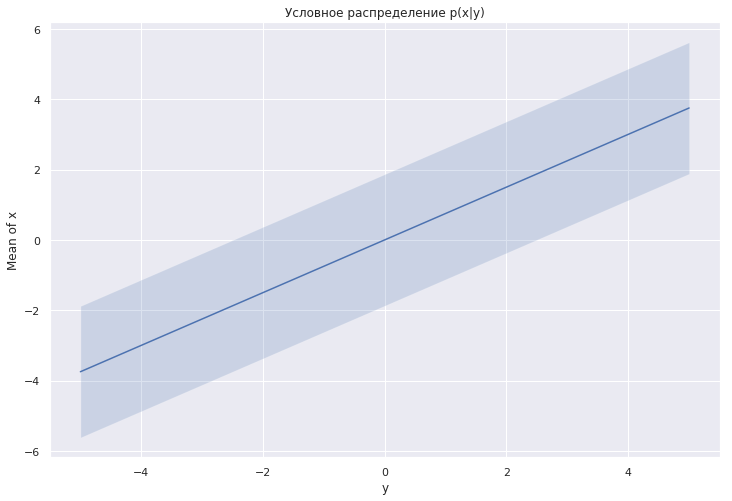

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(y, mu)
plt.fill_between(y, mu - 2 * np.sqrt(var), mu + 2 * np.sqrt(var), alpha=0.2)
plt.title('Условное распределение p(x|y)')
plt.ylabel('Mean of x')
plt.xlabel('y')
plt.show()

### Ядра и, в частности, ~~пушечные~~ гауссовы

$$\mathrm{kern}: X \times X \rightarrow \mathbb{R} $$

Ядро это функция, которая отображает декартово произведение некоторого пространства с самим собой на действительную ось.

Больше инфы про ядра: http://www.machinelearning.ru/wiki/index.php?title=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D1%8F%D0%B4%D1%80%D0%B0

#### Гауссово ядро

$$\mathrm{kern}(x, y) \sim \exp\left( -\frac{||x - y||_2}{2 \sigma^2} \right)$$

In [69]:
class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma
    def __call__(self, x_train, x_test):
        # l2-норма между матрицами x_train[N, K] y_train[M, K]
        # Выходом должна быть матрица [N, M]
        dist = (np.sum(x_train**2, 1)[:, None] + 
                np.sum(x_test**2, 1)[None, :] - 
                2 * x_train.dot(x_test.T)) 
        k = np.exp(- dist / self.sigma**2 / 2)
        return k

### Причём здесь гауссовы процессы?

Пусть у нас есть выборка $X_{train}, y_{train}$ и есть $X_{test}$ для которых мы хотим построить вероятностную модель для $y_{test}$. А ещё мы выбрали некоторое ядро $\mathrm{kern}(\cdot, \cdot)$.

Тогда гауссова регрессия(гауссов процесс) записывается следующим образом:

$$p(X_{test}, y_{test}, X_{train}, y_{train}) = \mathcal{N}\left( 0 , \begin{bmatrix}K + \sigma^2 I & K_* \\ K_*^T & K_{**} \end{bmatrix} \right), $$

где

$$K = \mathrm{kern}(X_{train}, X_{train})$$

$$K_{*} = \mathrm{kern}(X_{train}, X_{test})$$

$$K_{**} = \mathrm{kern}(X_{test}, X_{test})$$

Т.е. матрица ковариаций это матрица ядра. Как мы увидим дальше, выбор ядра __очень важен__ и зависит от задачи.

Тогда наша задача это найти следующее распределение:

$$p(y_{test} | X_{test}, X_{train}, y_{train}) \sim \mathcal{N}\left(K_{*}^T (K + \sigma^2 I)^{-1} y_{train}, K_{**} - K_{*} (K + \sigma^2 I)^{-1} K_{*}^T\right)$$

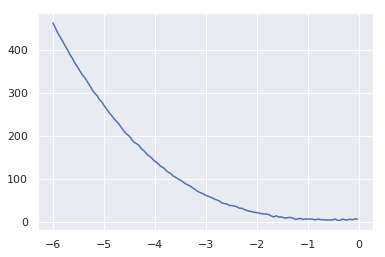

In [70]:
plt.plot(X_train[:, 0], Y_train.ravel())

### Какое сейчас время? Время Гауссовой Регрессии!

In [71]:
class GaussianRegression:
    def __init__(self, kernel, X, y, noise=EPS):
        self.kernel = kernel
        self.X_train = X
        self.y_train = y
        self.noise = noise
        
        self.K_train = self.kernel(self.X_train, self.X_train)
        self.L_train = np.linalg.cholesky(self.K_train + self.noise * np.eye(len(X_train)))
        self.K_inv = np.linalg.pinv(self.K_train + self.noise * np.eye(len(X_train)))
    
    def predict(self, X_test):
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        # std
        std = np.sqrt(np.diag(cov))
        
        return mu.reshape((len(X_test), -1)), std.reshape((len(X_test), -1))
    
    def sample(self, X_test, n=1):
        # copy-paste code above
        
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        samples = np.random.multivariate_normal(size=n, mean=mu.ravel(), cov=cov)
        
        return samples.T

In [72]:
kernel = GaussianKernel(1.)

In [73]:
gregressor = GaussianRegression(kernel=kernel, X=X_train, y=Y_train, noise=1e-3)

In [74]:
mu, std = gregressor.predict(X)
samples = gregressor.sample(X, n=3).T

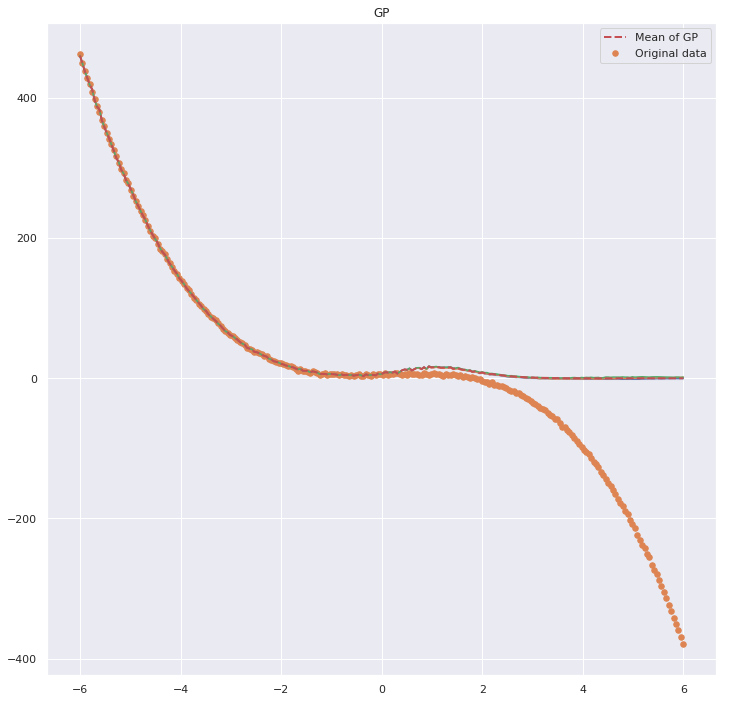

In [75]:
plot_gp(X_train=X[:, 0], y_train=Y, 
        X_test=X[:, 0], samples=samples, mu=mu, std=std)

## GPy

Чтобы не прогать самим и не делать кучу ошибок, лучше использовать готовые решения :)


In [76]:
import GPy

In [77]:
kern = GPy.kern.RBF(input_dim=5, lengthscale=1., variance=1.)

In [78]:
# kern.plot()

In [79]:
# нормальные ребята используют для регрессии GPRegression
# clf=GPy.models.GPRegression(X_train, y_train, kern)

In [80]:
# но нам и так нормально
clf=GPy.core.GP(X=X_train, 
                Y=Y_train.reshape(-1, 1), 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=1e-2))

In [81]:
clf.optimize(messages=True)

In [82]:
mu, cov = clf.predict(X, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=3, mean=mu.ravel(), cov=cov)

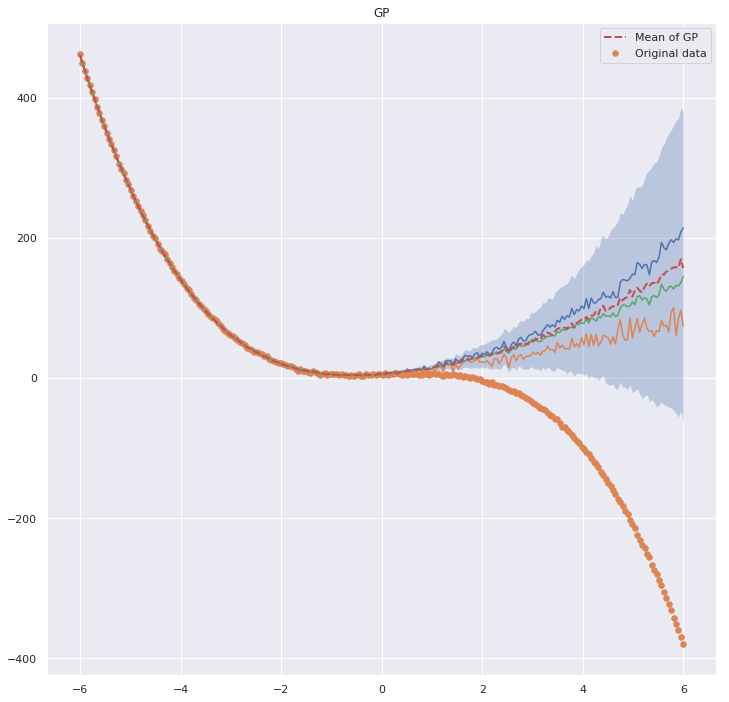

In [83]:
plot_gp(X_train=X[:, 0], y_train=Y, 
        X_test=X[:, 0], samples=samples, mu=mu, std=std)

### MOAR KERNELS

In [84]:
kern = GPy.kern.Poly(input_dim=4)

In [85]:
clf=GPy.core.GP(X=X_train, 
                Y=Y_train.reshape(-1, 1), 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=2.))

In [86]:
clf.optimize(messages=True, optimizer='lbfgsb')

In [87]:
mu, cov = clf.predict(X, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=10, mean=mu.ravel(), cov=cov)

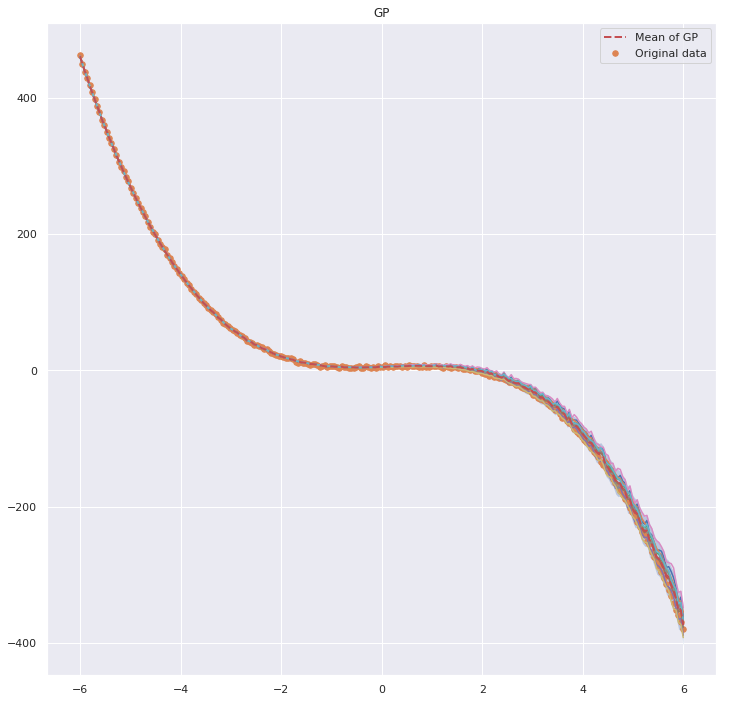

In [88]:
plot_gp(X_train=X[:, 0], y_train=Y, 
        X_test=X[:, 0], samples=samples, mu=mu, std=std)

# Deep Kernel Learning with GP

Если у вас Анаконда, то вам нужно запустить следующую команду для установки PyTorch v1.0:

```
conda install pytorch-nightly-cpu -c pytorch
```

Если чистый Питон с pip:
```
pip install numpy torchvision_nightly
pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
```


После установки PyTorch, устанавливаем gpytorch:

```
pip install gpytorch
```

Рассмотрим пару примеров на использование KISS-GP и KISS-GP с Kernel Learning. 

![](kiss.png)

In [89]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [90]:
n = 60
xx, yy = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
train_x = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

# sin( 2 * pi * (x0+x1))
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (4 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)

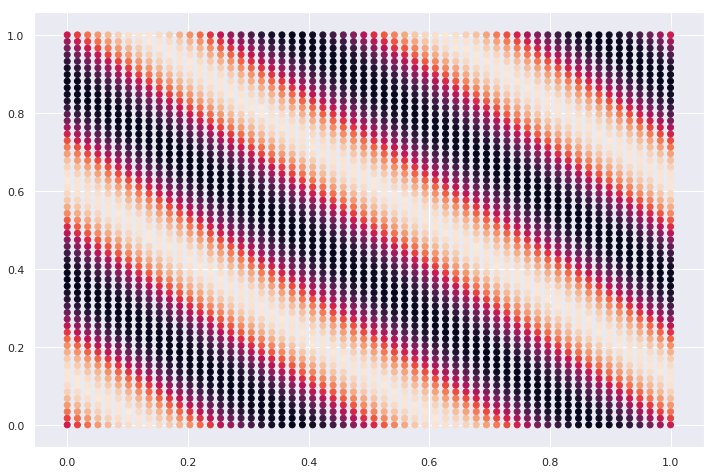

In [91]:
plt.figure(figsize=(12, 8));
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y);
plt.show();

In [92]:
kernel = gpytorch.kernels.PeriodicKernel()

In [93]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                kernel,
            ), grid_size=grid_size, num_dims=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood, kernel)

In [94]:
# оптимизатор нейронки
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

In [95]:
# лосс-функция
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [96]:
def train(training_iterations = 50):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        #for p in list(model.parameters()):
        #    p.grad[p.grad != p.grad] = 0.
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

%time train()

Iter 1/50 - Loss: 1.061
Iter 2/50 - Loss: 1.004
Iter 3/50 - Loss: 0.903
Iter 4/50 - Loss: 0.767
Iter 5/50 - Loss: 0.633
Iter 6/50 - Loss: 0.576
Iter 7/50 - Loss: 0.610
Iter 8/50 - Loss: 0.600
Iter 9/50 - Loss: 0.520
Iter 10/50 - Loss: 0.425
Iter 11/50 - Loss: 0.363
Iter 12/50 - Loss: 0.342
Iter 13/50 - Loss: 0.326
Iter 14/50 - Loss: 0.292
Iter 15/50 - Loss: 0.224
Iter 16/50 - Loss: 0.145
Iter 17/50 - Loss: 0.087
Iter 18/50 - Loss: 0.067
Iter 19/50 - Loss: 0.039
Iter 20/50 - Loss: -0.029
Iter 21/50 - Loss: -0.109
Iter 22/50 - Loss: -0.159
Iter 23/50 - Loss: -0.199
Iter 24/50 - Loss: -0.254
Iter 25/50 - Loss: -0.316
Iter 26/50 - Loss: -0.367
Iter 27/50 - Loss: -0.418
Iter 28/50 - Loss: -0.471
Iter 29/50 - Loss: -0.529
Iter 30/50 - Loss: -0.572
Iter 31/50 - Loss: -0.631
Iter 32/50 - Loss: -0.672
Iter 33/50 - Loss: -0.617
Iter 34/50 - Loss: -0.790
Iter 35/50 - Loss: -0.781
Iter 36/50 - Loss: -0.889
Iter 37/50 - Loss: -0.880
Iter 38/50 - Loss: -0.874
Iter 39/50 - Loss: -1.032
Iter 40/50 - L

In [97]:
model.eval()
likelihood.eval()

GaussianLikelihood()

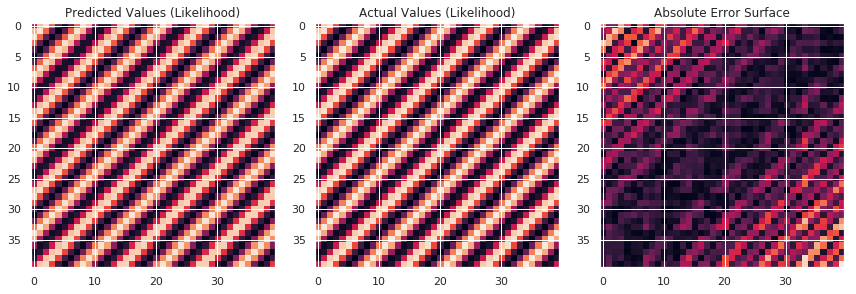

In [98]:
n = 40
xx, yy = np.meshgrid(np.linspace(-1, 2, n), np.linspace(-1, 2, n))
test_x = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (4 * math.pi))).view(n, n)

with torch.no_grad(), gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    
# Предсказания
ax[0].imshow(pred_labels)
ax[0].set_title('Predicted Values (Likelihood)')

# Ground truth
ax[1].imshow(test_y_actual)
ax[1].set_title('Actual Values (Likelihood)')

# Ошибки
ax[2].imshow(delta_y)
ax[2].set_title('Absolute Error Surface')

fig.tight_layout()

# Scalabel GP + Deep Learning

Зачем подбирать ядра и мучиться если можно обучить нейросетку?

In [99]:
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor

if not os.path.isfile('elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', 'elevators.mat')
    
data = torch.Tensor(loadmat('elevators.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

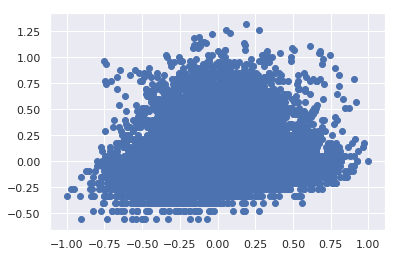

In [100]:
plt.scatter(X[:, 0], y);

In [101]:
data_dim = train_x.size(-1)

class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(1000, 500))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(500, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, 2))         
                                                             
feature_extractor = LargeFeatureExtractor()

In [102]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, kernel):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(kernel),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # пропускаем данные через нейронку
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
        
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [103]:
kernel = gpytorch.kernels.RBFKernel(ard_num_dims=2)

In [104]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood, kernel=kernel)

In [105]:
model.train()
likelihood.train()

GaussianLikelihood()

In [106]:
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.1)

In [107]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [108]:
def train(training_iterations = 60):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        
with gpytorch.settings.use_toeplitz(True):
    %time train()

Iter 1/60 - Loss: 0.780
Iter 2/60 - Loss: 0.730
Iter 3/60 - Loss: 0.691
Iter 4/60 - Loss: 0.656
Iter 5/60 - Loss: 0.617
Iter 6/60 - Loss: 0.577
Iter 7/60 - Loss: 0.537
Iter 8/60 - Loss: 0.497
Iter 9/60 - Loss: 0.455
Iter 10/60 - Loss: 0.413
Iter 11/60 - Loss: 0.370
Iter 12/60 - Loss: 0.325
Iter 13/60 - Loss: 0.279
Iter 14/60 - Loss: 0.233
Iter 15/60 - Loss: 0.186
Iter 16/60 - Loss: 0.142
Iter 17/60 - Loss: 0.098
Iter 18/60 - Loss: 0.051
Iter 19/60 - Loss: 0.009
Iter 20/60 - Loss: -0.037
Iter 21/60 - Loss: -0.074
Iter 22/60 - Loss: -0.107
Iter 23/60 - Loss: -0.146
Iter 24/60 - Loss: -0.204
Iter 25/60 - Loss: -0.225
Iter 26/60 - Loss: -0.240
Iter 27/60 - Loss: -0.258
Iter 28/60 - Loss: -0.257
Iter 29/60 - Loss: -0.266
Iter 30/60 - Loss: -0.287
Iter 31/60 - Loss: -0.323
Iter 32/60 - Loss: -0.383
Iter 33/60 - Loss: -0.329
Iter 34/60 - Loss: -0.257
Iter 35/60 - Loss: -0.219
Iter 36/60 - Loss: -0.209
Iter 37/60 - Loss: -0.263
Iter 38/60 - Loss: -0.413
Iter 39/60 - Loss: -0.447
Iter 40/60 - L

In [109]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.fast_pred_var():
    preds = model(test_x)

In [110]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 6.7548933029174805
